In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import re

%matplotlib inline

In [3]:
import edmonds

In [10]:
from networkx.drawing.nx_pydot import graphviz_layout
from shapely.geometry import Point

In [4]:
plt.rcParams['figure.figsize'] = 10,7
plt.rcParams['font.size'] = 15

In [5]:
# ellista es csucspozicio fix az osszes szeletre
nlist = pd.read_csv('../edgelists_yearlyslice/nodelist.csv',index_col=0)
nlist = pd.concat([nlist,pd.DataFrame([[0,47.498382,19.040471,None,None]],columns=nlist.columns)],ignore_index=True)


In [6]:
varosok = gpd.GeoDataFrame(gpd.read_file('../iwiw_data/terkep/OSN_region.shp'), crs = 'epsg:23700')
iwiw_codes = nlist.set_index('CityName')['CityId'].to_dict()
varosok['iwiw_code'] = varosok['HELYES']\
    .str.normalize('NFKD')\
    .str.encode('ascii', errors='ignore')\
    .str.decode('utf-8').map(iwiw_codes)

In [7]:
nlist['geometry'] = nlist.apply(lambda r: Point(r['Longitude'],r['Latitude']),axis=1)
nlist['eov_x'] = gpd.GeoDataFrame(nlist,crs = 'epsg:4326').to_crs('epsg:23700').geometry.map(lambda p: p.coords[0][0])
nlist['eov_y'] = gpd.GeoDataFrame(nlist,crs = 'epsg:4326').to_crs('epsg:23700').geometry.map(lambda p: p.coords[0][1])
nlist['geometry_eov'] = gpd.GeoDataFrame(nlist,crs = 'epsg:4326').to_crs('epsg:23700')['geometry']

In [8]:
valid = set(gpd.sjoin(varosok,gpd.GeoDataFrame(nlist,geometry="geometry_eov"),op='contains')['CityId'])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:23700 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [9]:
nlist = nlist[nlist.CityId.isin(valid)]

In [11]:
lims = np.array([2003.0,2005.5,2009.5,2013.0])

In [18]:
# ellista es csucspozicio fix az osszes szeletre
pos = nlist.set_index('CityId').apply(lambda row: [row['eov_x'],row['eov_y']],axis=1).to_dict()

elists = {1:[], 2:[], 3:[]}

for f in os.listdir('../edgelists_yearlyslice/'):
    if 'edgelist' in f:
        # ev a fajlnevbol
        year = f.split('_')[1].split('-')[0]
        print(year, np.digitize(float(year),lims))
        elist  = pd.read_csv('../edgelists_yearlyslice/'+f,index_col=0)
        elist = elist[(elist["CityId"].isin(valid)&elist["InvitorCityId"].isin(valid))]
        elists[np.digitize(float(year),lims)].append(elist)

for k in elists:
    elists[k] = pd.concat(elists[k]).groupby(['CityId','InvitorCityId']).sum().reset_index()

2009 2
2008 2
2005 1
2011 3
2003 1
2007 2
2006 2
2010 3
2012 3
2004 1


In [19]:
limname = {1:'2003-2005', 2:'2006-2009',3:'2010-2012'}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


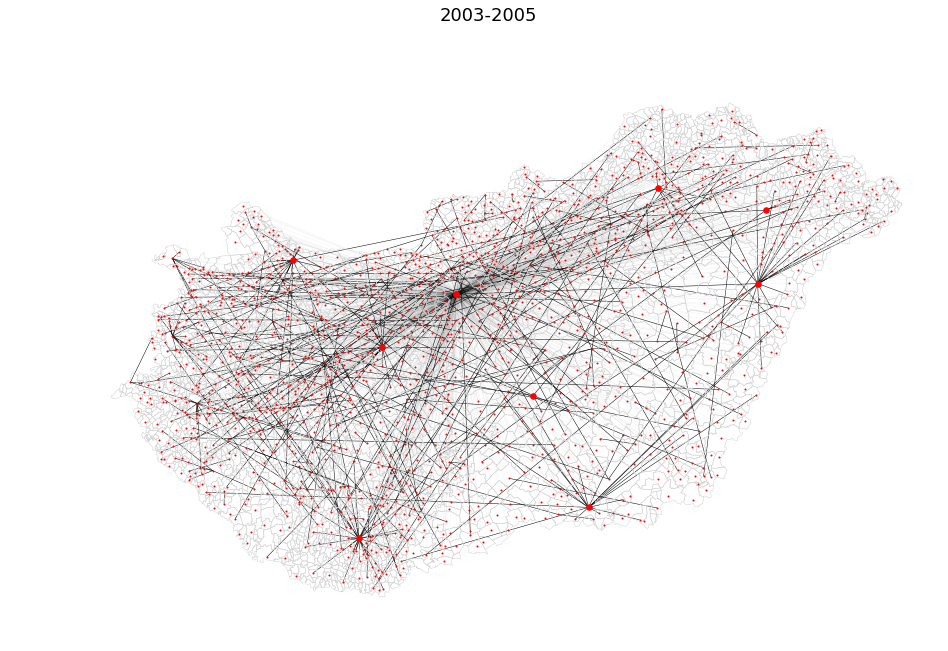

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


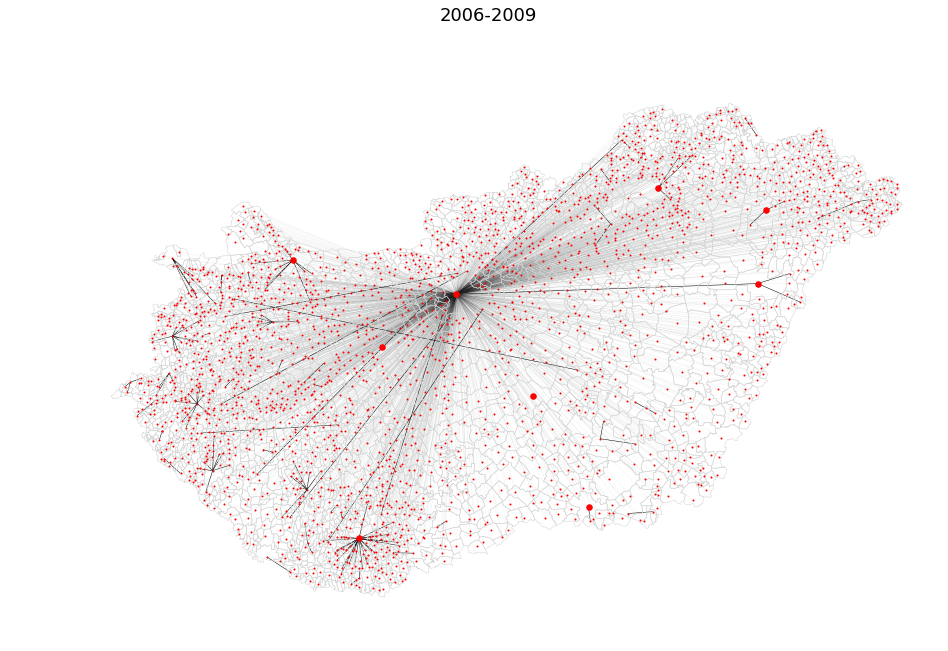

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


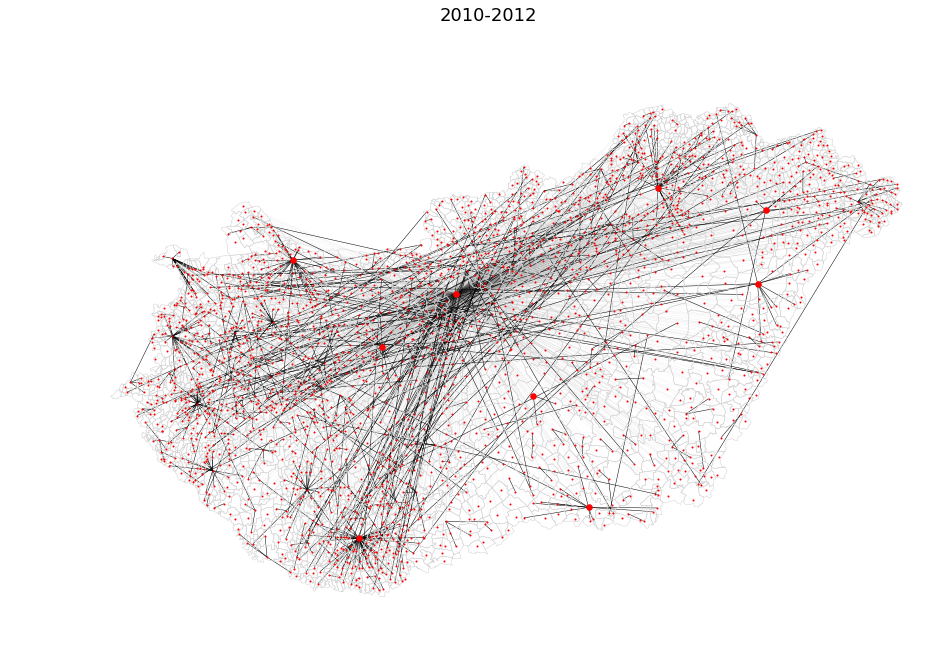

In [26]:
for k in elists:
    elist = elists[k]
# Normalizing outgoing edge weights to get outgoing probability
    # creating $-\log(p)$ as future edge weights.
    norm = elist.groupby('InvitorCityId').sum()['NumOutInvs'].to_dict()
    elist['norm'] = elist['InvitorCityId'].map(norm)
    elist['p'] = elist['NumOutInvs'] / elist['norm']
    elist['weight'] = elist['p'].map(np.log)*(-1)
#         elist['InvitorCityId'] = elist['InvitorCityId'].map(str)
#         elist['CityId'] = elist['CityId'].map(str)

    # sulyozott graf
    G = nx.DiGraph()
    G.add_weighted_edges_from(elist[['InvitorCityId','CityId','weight']].values,weight='weight')

#         D = {}
#         for n in G.nodes():
#             D[n] = {}
#             for v in G[n]:
#                 D[n][v] = G[n][v]['weight']
#         try:
#             temp = edmonds.mst('379',D)

#             R = {}
#             for n in temp:
#                 R[int(n)] = {}
#                 for v in temp[n]:
#                     R[int(n)][int(v)] = {'weight' : temp[n][v]}

#             T = nx.from_dict_of_dicts(R)

#         try:

#             legrovidebb eleresi utak Budapestrol
    tree_l = nx.shortest_paths.weighted.single_source_dijkstra_path_length(G,source=379)

    # pontos elek grafja
    elist['source_l'] = elist['InvitorCityId'].map(tree_l)
    elist['target_l'] = elist['CityId'].map(tree_l)
    elist['diff_l'] = elist['target_l'] - elist['source_l']
    tlist = elist[np.abs(elist['diff_l']-elist['weight'])<1e-5]
    tlist[['CityId','InvitorCityId']].to_csv('edges_'+str(k)+'.csv',header=True,index=False)
    

    T = nx.Graph()
    T.add_edges_from(tlist[['CityId','InvitorCityId']].values)
    nlist[nlist.CityId.isin(set(T.nodes()))][['CityId','CityName','PopLog','eov_x','eov_y']].to_csv('nodes_'+str(k)+'.csv',header=True,index=False)
#         # mennyire faszeru a pontos elek grafja (~hany olyan csucs van, ahova tobb regrovidebb utvonal is megy)
#         budapest_component_nodes = [c for c in nx.connected_components(T) if 379 in c][0]
#         budapest_component  = nx.subgraph(T,budapest_component_nodes)
#         print(year,"mennyire fa",len(budapest_component.edges())-len(budapest_component.nodes()))

#         # hany lepesben ertem el a telepulest Budapestrol
#         nlist['steps_'+year] = nlist['CityId'].map(nx.shortest_paths.single_source_dijkstra_path_length(T,source=379,weight=None))

    # poltolas
    fig,ax = plt.subplots(1,1,figsize=(20,10))
    varosok.boundary.plot(ax=ax,color='lightgrey',linewidth=0.5)
#     pos2 = graphviz_layout(T, prog="twopi")
    nx.draw_networkx_nodes(T,pos,nodelist = list(set(nlist[~(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes()))),node_size=1,ax=ax)
    nx.draw_networkx_nodes(T,pos,nodelist = list(set(nlist[(nlist['PopLog']>5)]['CityId'].tolist()).intersection(set(T.nodes()))),node_size=30,ax=ax)
    nx.draw_networkx_edges(T,pos,nodelist=nlist['CityId'].tolist(),width=[0.025 if u==379 else 0.5 for u,v in T.edges()],ax=ax)

#     nx.draw_networkx_nodes(T,pos2,node_size=1,ax=ax[1])
#     nx.draw_networkx_edges(T,pos2,width=[0.01 if u==379 else 0.5 for u,v in T.edges()],ax=ax[1])
#         ax[1].hist(nlist['steps_'+year],bins=4,range=(0,4))
#         ax[1].set_xlim(0,3.5)
#         ax[1].set_ylim(0,2500)
    fig.suptitle(limname.get(k))
    plt.axis('off')
    ax.set_aspect('equal')
    
    
    plt.savefig('../figs/dijkstra_'+str(k)+'.pdf',fonttype=42)
    plt.show()
#         except:
#             pass

In [ ]:
for k in elists:
    elist = elists[k]
# Normalizing outgoing edge weights to get outgoing probability
    # creating $-\log(p)$ as future edge weights.
    norm = elist.groupby('InvitorCityId').sum()['NumOutInvs'].to_dict()
    elist['norm'] = elist['InvitorCityId'].map(norm)
    elist['p'] = elist['NumOutInvs'] / elist['norm']
    elist['weight'] = elist['p'].map(np.log)*(-1)
    elist = pd.concat([elist[elist['norm']>20],pd.DataFrame([[379,0,0,0,0,0]],columns=elist.columns)],ignore_index=True)

    # sulyozott graf
    G = nx.DiGraph()
    G.add_weighted_edges_from(elist[['InvitorCityId','CityId','weight']].values,weight='weight')
    
#     largest_conn_comp = nx.connected_components()


#             legvaloszinubb eleresi ut Budapestrol Endmonds-algoritmussal
    tree_l = nx.minimum_spanning_arborescence(G)

    # poltolas
    fig,ax = plt.subplots(1,1,figsize=(15,8))
#     pos2 = graphviz_layout(T, prog="twopi")
    nx.draw_networkx_nodes(tree_l,pos,node_size=1,ax=ax)
    nx.draw_networkx_edges(tree_l,pos,width=[0.01 if u==379 else 0.5 for u,v in tree_l.edges()],ax=ax)

#     nx.draw_networkx_nodes(T,pos2,node_size=1,ax=ax[1])
#     nx.draw_networkx_edges(T,pos2,width=[0.01 if u==379 else 0.5 for u,v in T.edges()],ax=ax[1])
#         ax[1].hist(nlist['steps_'+year],bins=4,range=(0,4))
#         ax[1].set_xlim(0,3.5)
#         ax[1].set_ylim(0,2500)
    fig.suptitle(limname.get(k))
#         plt.savefig('./figs/' + year +'_hierarchy.png',density=600)
    plt.show()
#         except:
#             pass

# Shapes


In [6]:
# read in shapefile
varosok = gpd.read_file('../iwiw_data/terkep/OSN_region.shp')[['HELYES', 'KSHK', 'geometry']]

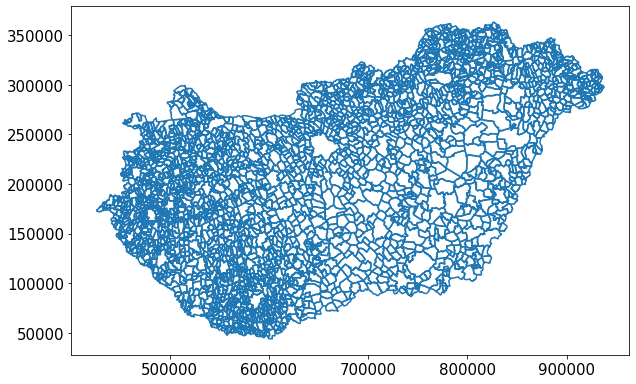

In [7]:
# read in shapefile
varosok = gpd.read_file('../iwiw_data/terkep/OSN_region.shp')[['HELYES', 'KSHK', 'geometry']]

# have a look inside
varosok.boundary.plot()
# this is in EOV coordinate system: EPSG:23700!!!
# the nodelist file was EPSG:4326 (lon,lat)

In [1]:
varosok

NameError: name 'varosok' is not defined

In [9]:
# somehow we should connect the map to the network data
iwiw_codes = nlist.set_index('CityName')['CityId'].to_dict()

In [10]:
# adding nodelist index to map

iwiw_codes = nlist.set_index('CityName')['CityId'].to_dict()
varosok['iwiw_code'] = varosok['HELYES']\
    .str.normalize('NFKD')\
    .str.encode('ascii', errors='ignore')\
    .str.decode('utf-8').map(iwiw_codes)

Checking how many settlements are not within the nodelist.

In [11]:
len(varosok.index)

3135

In [12]:
len(nlist.index)

2555

In [13]:
varosok.head(5)

,HELYES,KSHK,geometry,iwiw_code
0,Aba,1737,"POLYGON ((607990.320 193902.270, 608020.000 19...",31353.0
1,Abádszalók,1244,"POLYGON ((760867.000 239566.000, 761030.000 24...",16547.0
2,Abaliget,1254,"POLYGON ((574303.000 91680.000, 574789.000 915...",60960.0
3,Abasár,2455,"POLYGON ((722942.000 279255.000, 723238.000 27...",21942.0
4,Abaújalpár,1566,"POLYGON ((811849.000 331856.000, 812217.000 33...",NaN


Nem minden telepuleshez tartozik node! -> Balazs/Martin?

In [14]:
len(varosok[pd.isnull(varosok['iwiw_code'])].index) + len(nlist.index)

3133

Mapping the nodelist log population to the map.

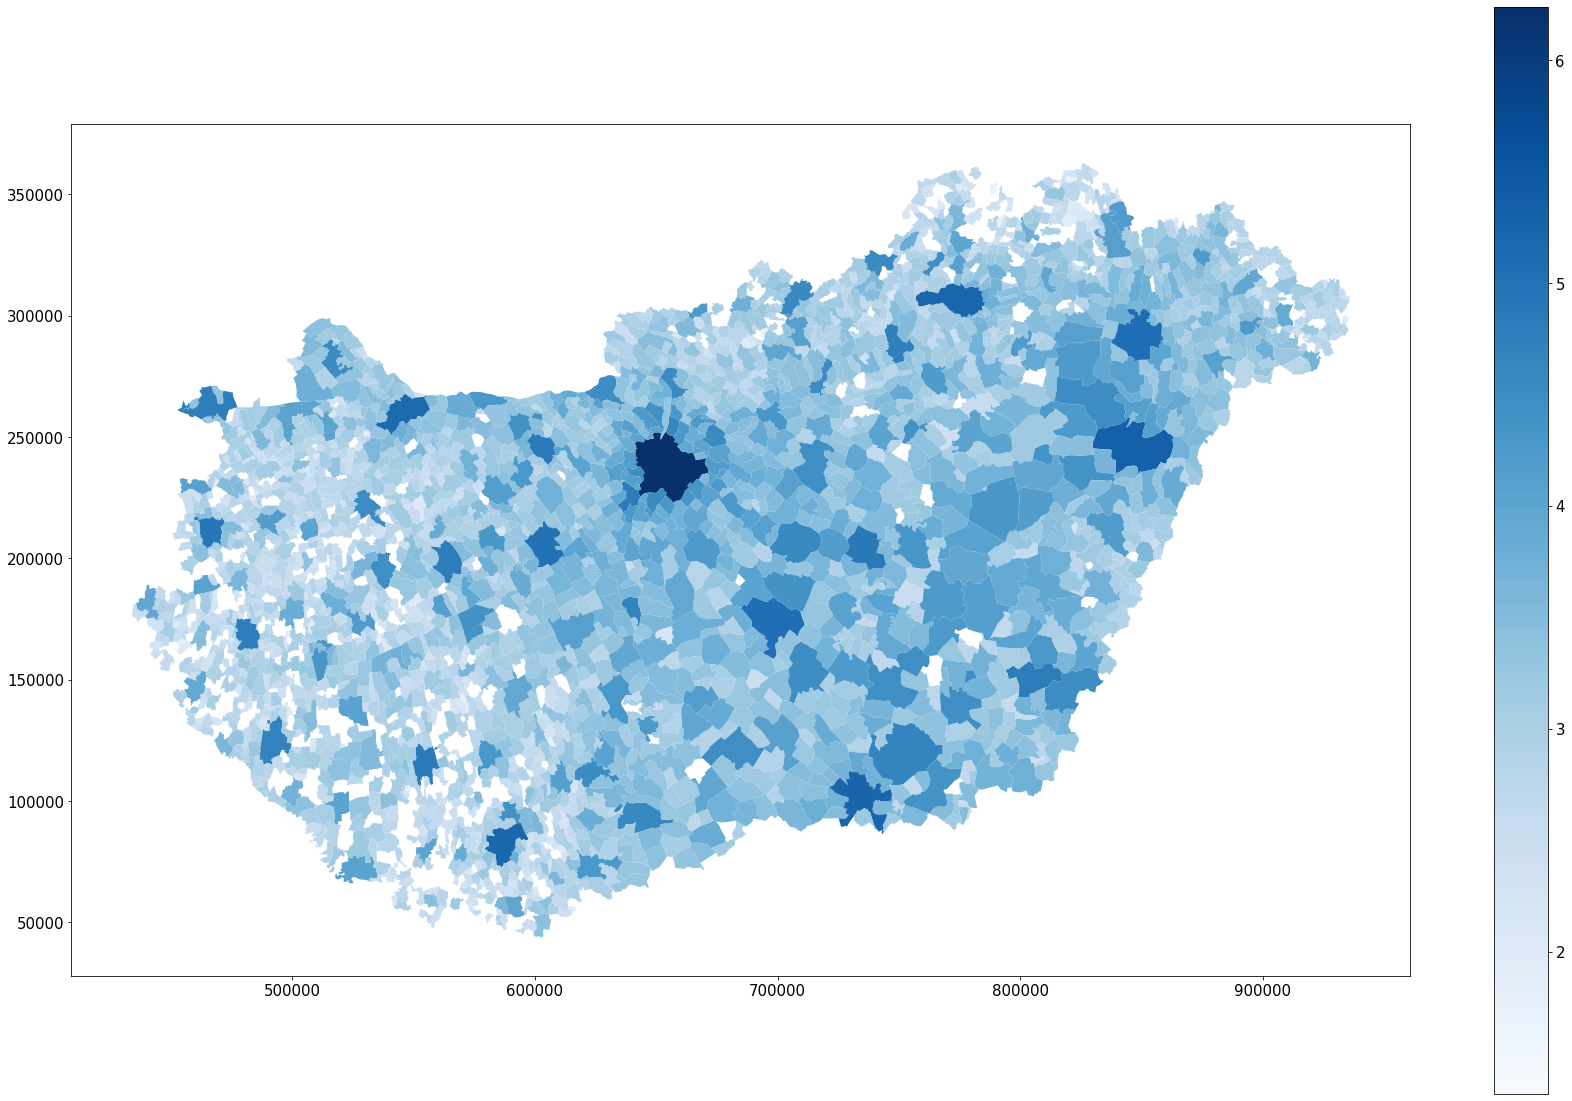

In [15]:
varosok['PopLog'] = varosok['iwiw_code'].map(nlist.set_index('CityId')['PopLog'].to_dict())

varosok.dropna(subset=['PopLog']).plot(column='PopLog',cmap='Blues',legend=True,figsize=(30,20))

Mean steps to reach settlement with the Dijkstra method from Budapest throughout years 2005-2012.

In [17]:
nlist

,CityId,Latitude,Longitude,PopLog,CityName,steps_2003,steps_2011,steps_2004,steps_2008,steps_2007,steps_2005,steps_2012,steps_2010,steps_2006,steps_2009
0,379,47.498382,19.040471,6.240560,Budapest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,380,47.531399,21.625978,5.317215,Debrecen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,381,48.103150,20.790198,5.222256,Miskolc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,382,46.254631,20.148602,5.230582,Szeged,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,383,46.076322,18.228075,5.195349,Pecs,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,135365,46.671334,16.889469,2.406540,Zala,NaN,2.0,NaN,2.0,2.0,NaN,NaN,2.0,2.0,2.0
2551,136163,46.592968,18.720803,2.990339,Pusztahencse,NaN,2.0,NaN,2.0,1.0,NaN,NaN,2.0,2.0,2.0
2552,137163,47.896722,22.161449,2.758155,Nyirderzs,NaN,2.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,2.0
2553,137166,47.015659,16.850835,2.440909,Pacsony,NaN,2.0,NaN,NaN,1.0,NaN,NaN,3.0,2.0,NaN


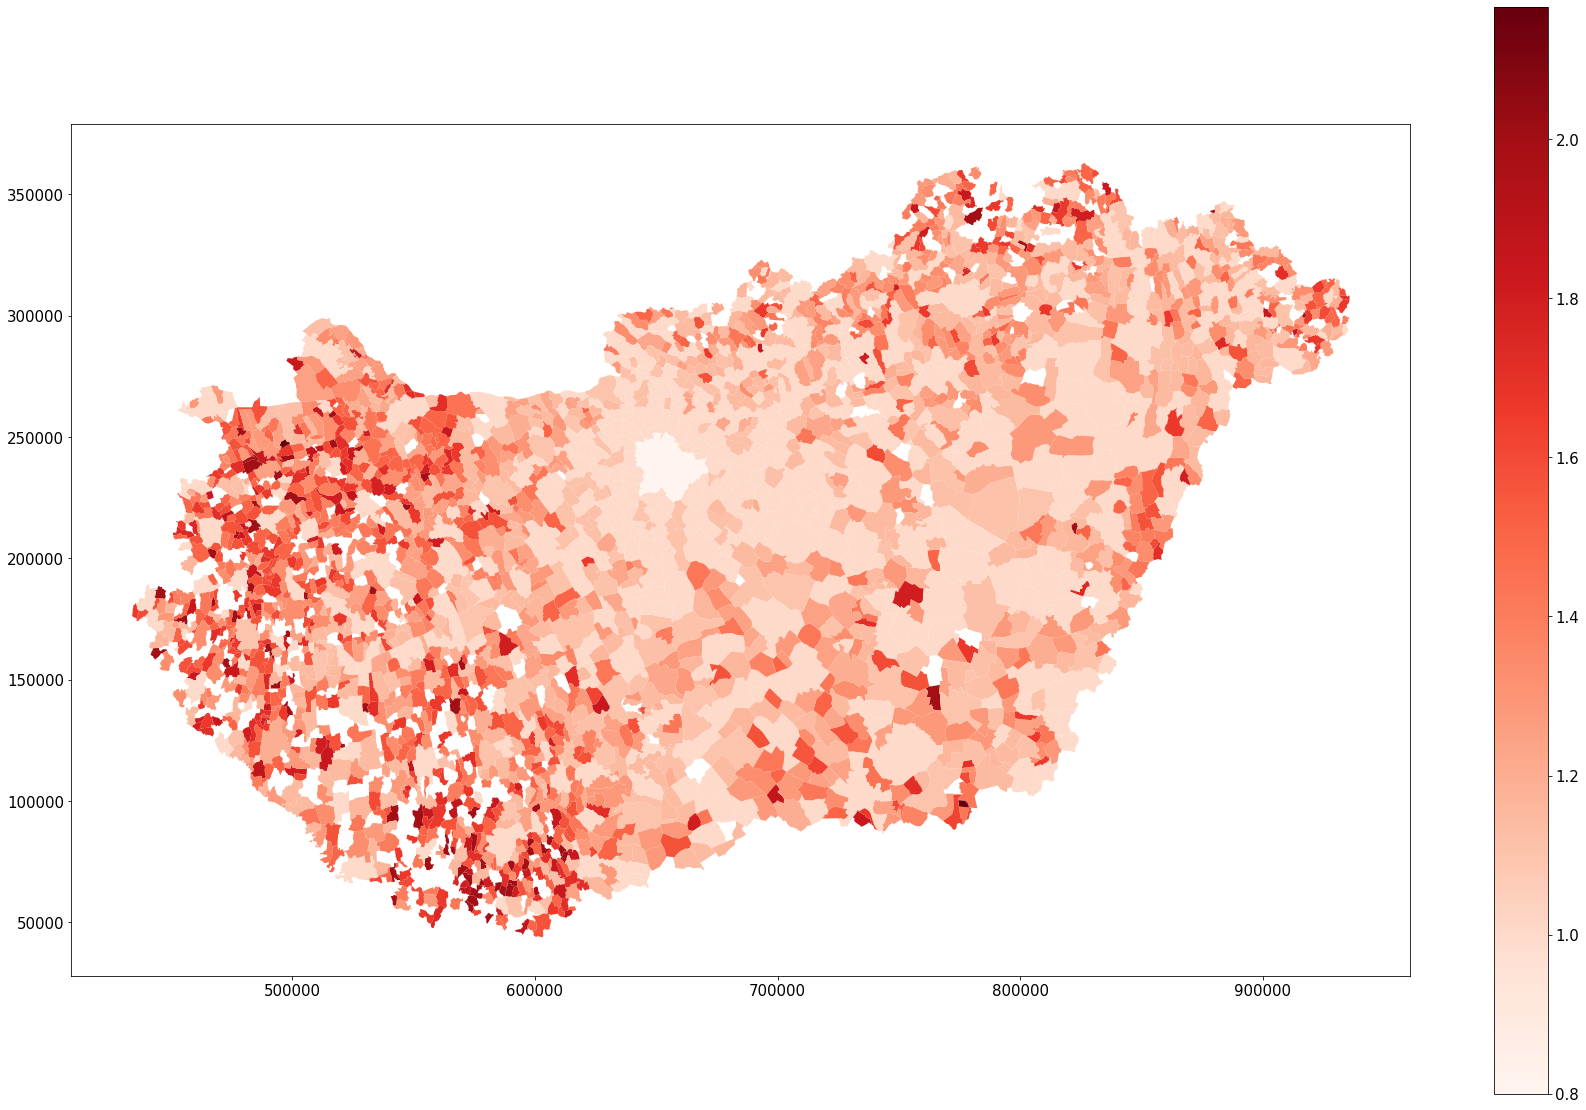

In [16]:
varosok['mean_steps'] = varosok['iwiw_code'].map(nlist.set_index('CityId')[[c for c in nlist.columns if "step" in c]].mean(axis=1).to_dict())

varosok.dropna(subset=['mean_steps']).plot(column='mean_steps',cmap='Reds',legend=True,figsize=(30,20),vmin=0.8)